# MoMA Multi-Class Classification of Artworks with ResNet50

**Art's classification recognition can help museums and archivist organize and recommend artworks.**

Some artworks in digitalized format blur the boundaries between classifications. For example, some printings resemble photographs, while certain photographs are made to look like drawings. This makes classifying artworks challenging but also interesting for machine learning applications.

The goal of this project is to build machine learning model that can automatically classify digitalized artworks into three categories - photographs, drawings, and printings - using data from Museum of Modern Art (MoMA).

To tackle this problem, I use ResNet50, a deep convolutional neutal network known for its ability to recognize patterns in images. I freeze first three layer and finetune layer 4 and the fully connected layer. The dataset comes from [Maven Analytics’ Data Playground](https://mavenanalytics.io/data-playground/the-museum-of-modern-art-(moma)-collection), which contains over 150,000 records of artworks with metadata such as title, artist, medium, classification, and image links.

The finaml model reach validation accuracy at 88.4% with 0.88 F1 score - showing that the model is balanced and performes consitently on three classes of artworks

The project was inspired by [Alaeddine Grine’s article: Artwork Classification in PyTorch](https://medium.com/@alaeddine.grine/artwork-classification-in-pytorch-b4f3395b877e). In his work, Grine focused on classifying artworks by artistic style (e.g., painting, mural, sculpture) using a curated dataset that spans from the 14th to the 21st century. His project showed how deep learning can be applied to art history, helping us understand the evolution of artistic styles.


## Environment



In [ ]:
# # install required package befor proceeding
# !pip install pandas numpy matplotlib requests bs4 tqdm torch pillow torchvision scikit-learn

In [1]:
# mount drive
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [2]:
# check GPU
!nvidia-smi

/bin/bash: line 1: nvidia-smi: command not found


## Imports



In [3]:
# data handling
import os
import pandas as pd
import numpy as np
import random
import glob
import pickle

# byte streams and warnings
from io import BytesIO
import warnings

# web scrap
import requests
from bs4 import BeautifulSoup

# image processing
from PIL import Image

# visualization
import matplotlib.pyplot as plt

# PyTorch
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

# pretrained model
from torchvision import models, transforms

# metrics and evaluation
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score

# progress show
from tqdm import tqdm

#json file
import json

# turn off warnings
warnings.filterwarnings('ignore')

# set column view
pd.set_option("display.max_columns", None)

print("Libraries imported")

Libraries imported


In [4]:
"""
Set randomness control on PyTorch, CuDNN, Numpy, and Torchvision for reproducibility
Source: https://colab.research.google.com/drive/1zoEgSwQ40uXBys83X7ajW2oInve91S4w?usp=sharing#scrollTo=mrN7pm3ZXLju
"""

# set seeds
seed = 50
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.cuda.manual_seed_all(seed)

# force deterministic algorithms
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

print("Random seeds set")

Random seeds set


## Dataset Preparation

I use only `ObjectID`, `Classification`, and `ImageURL` for this project. The dataset initially contains many missing entries, so I first drop rows that have no image URL or missing class labels. To avoid duplicates, I check and remove any rows with repeated ObjectIDs. I also sort data via `Classification` and `ObjectID` to ensure images under same classification are grouped together. This make it reproducible and easier to perform balanced sampling and  

Before performing sampling, I curate 100 images and set them aside so they do not appear in the training data. These dataset will be used in the demonstration with web applocation.

For model training, I randomly sample 3000 images from each class to balance the dataset. I download each image using its URL and save it locally, making sure each file corresponds to its ObjectID.

### Load dataset

In [5]:
# load dataset
art = pd.read_csv("PATH_TO_DATASET")
art.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 157630 entries, 0 to 157629
Data columns (total 30 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   Title               157582 non-null  object 
 1   Artist              156361 non-null  object 
 2   ConstituentID       156361 non-null  object 
 3   ArtistBio           151542 non-null  object 
 4   Nationality         156361 non-null  object 
 5   BeginDate           156361 non-null  object 
 6   EndDate             156361 non-null  object 
 7   Gender              156361 non-null  object 
 8   Date                155611 non-null  object 
 9   Medium              148383 non-null  object 
 10  Dimensions          148971 non-null  object 
 11  CreditLine          156080 non-null  object 
 12  AccessionNumber     157630 non-null  object 
 13  Classification      157630 non-null  object 
 14  Department          157630 non-null  object 
 15  DateAcquired        150881 non-nul

### Select required columns

In [6]:
# drop unused columns
art_df = art[["ObjectID", "Classification", "ImageURL"]]

# check ID duplicates
duplicates = art_df.duplicated(["ObjectID"], keep=False)
art_df = art_df[~duplicates]
art_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 157630 entries, 0 to 157629
Data columns (total 3 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   ObjectID        157630 non-null  int64 
 1   Classification  157630 non-null  object
 2   ImageURL        91043 non-null   object
dtypes: int64(1), object(2)
memory usage: 3.6+ MB


### Drop rows with missing data

In [7]:
# drop rows with no image url and no classification
no_url = art_df[~art_df["ImageURL"].astype(str).str.startswith("http")]
art_df = art_df.drop(no_url.index).dropna(subset=["Classification"]).reset_index(drop=True)
art_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 91043 entries, 0 to 91042
Data columns (total 3 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   ObjectID        91043 non-null  int64 
 1   Classification  91043 non-null  object
 2   ImageURL        91043 non-null  object
dtypes: int64(1), object(2)
memory usage: 2.1+ MB


### Select classification data

In [9]:
# Find the top three classifications based on counts
top_three_class = art_df["Classification"].value_counts().nlargest(3).index.tolist()
print("Top three classifications:", top_three_class)

Top three classifications: ['Photograph', 'Print', 'Drawing']


In [10]:
# filter for photograph, print, and drawing arts

art_filtered = art_df[art_df["Classification"] \
                      .isin(top_three_class)] \
                      .sort_values(by=["Classification", "ObjectID"]) \
                      .reset_index(drop=True)

print(f"Number of filtered arts: {len(art_filtered)}")
print("Number of arts in each classification: ")
print(art_filtered["Classification"].value_counts())

Number of filtered arts: 61674
Number of arts in each classification: 
Classification
Photograph    26460
Print         23670
Drawing       11544
Name: count, dtype: int64


In [12]:
art_filtered.head()

,ObjectID,Classification,ImageURL
0,9020,Drawing,https://www.moma.org/media/W1siZiIsIjI0OTM4NiJ...
1,9070,Drawing,https://www.moma.org/media/W1siZiIsIjUzMDY4MCJ...
2,9072,Drawing,https://www.moma.org/media/W1siZiIsIjUzMDY5NSJ...
3,9120,Drawing,https://www.moma.org/media/W1siZiIsIjUyOTk3NyJ...
4,9226,Drawing,https://www.moma.org/media/W1siZiIsIjI0ODEzOCJ...


### Set aside sample for demo

In [13]:
# reserve 60 images for demo
demo_df = art_filtered.sample(n=60, random_state=seed).reset_index(drop=True)

# drop these 60 out of the dataset for train/val set
art_filtered = art_filtered.drop(demo_df.index).reset_index(drop=True)

print(f"Number of arts in demo set: {len(demo_df)}")
print(f"Number of arts left: {len(art_filtered)}")

# save demo set
demo_path = "PATH_TO_DEMOSET"
os.makedirs(demo_path, exist_ok=True)
demo_csv = os.path.join(demo_path, "demo_artworks.csv")
demo_df.to_csv(demo_csv, index=False)
print(f"Demo set saved to {demo_csv}")


Number of arts in demo set: 60
Number of arts left: 61614
Demo set saved to /content/drive/MyDrive/ML-PROJECTS/MoMA/data/demo_set/demo_artworks.csv


### Sampling data for model train

In [14]:
n_samples_per_class = 3000

sampling_df = (
    art_filtered
    .groupby("Classification")
    .apply(lambda x: x.sample(n=min(len(x), n_samples_per_class), random_state=seed))
    .reset_index(drop=True)
)

print(f"Number of arts in sampling set: {len(sampling_df)}")
print(sampling_df["Classification"].value_counts())

Number of arts in sampling set: 9000
Classification
Drawing       3000
Photograph    3000
Print         3000
Name: count, dtype: int64


In [15]:
# check sampling dataset
sampling_df.head()

,ObjectID,Classification,ImageURL
0,201969,Drawing,https://www.moma.org/media/W1siZiIsIjM0Mjc2OCJ...
1,134940,Drawing,https://www.moma.org/media/W1siZiIsIjE4NDA5MCJ...
2,96390,Drawing,https://www.moma.org/media/W1siZiIsIjEyOTg0MiJ...
3,194394,Drawing,https://www.moma.org/media/W1siZiIsIjM0NzY2NiJ...
4,154956,Drawing,https://www.moma.org/media/W1siZiIsIjI0MjA1MiJ...


In [16]:
# save sampling dataset
csv_path = "PATH_TO_SAMPLINGSET"
sampling_df.to_csv(csv_path, index=False)
print(f"Sampling DataFrame saved to {csv_path}")

Sampling DataFrame saved to /content/drive/MyDrive/ML-PROJECTS/MoMA/data/sampling_df.csv


### Download images

I download images of art objects and saves it locally, use their IDs as name. It only needs to be run once. It is noted that I only download images that existing in `sample_df` only.


Downloading images is optional. We can also use the URLs directly during training. However, saving them locally improves performance and is much faster.

In [17]:
"""
Run only once.
"""

# path for images
image_path = "PATH_TO_IMAGE"
os.makedirs(image_path, exist_ok=True)

# headers for http request
HEADERS = {
    "User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 "
                  "(KHTML, like Gecko) Chrome/124.0.0.0 Safari/537.36"
}

# loop through the dataset by row
for idx, row in tqdm(sampling_df.iterrows(), total=len(sampling_df)):

    # set image name using `ObjectID` in dataframe
    img_name = os.path.join(image_path, f"{row['ObjectID']}.jpg")

     # avoid download existing image
    if not os.path.exists(img_name):
        try:
            # for each row send http request
            response = requests.get(row['ImageURL'], timeout=60, headers=HEADERS)
            response.raise_for_status()
            # write file in binary mode
            with open(img_name, "wb") as f:
                f.write(response.content)
        except Exception as e:
            print(f"Failed to download {row['ImageURL']}: {e}")
            continue


sampling_df['Img'] = sampling_df['ObjectID'].map(
    lambda x: os.path.join(image_path, f"{x}.jpg"))

sampling_df.head()

100%|██████████| 9000/9000 [31:03<00:00,  4.83it/s]


,ObjectID,Classification,ImageURL,Img
0,201969,Drawing,https://www.moma.org/media/W1siZiIsIjM0Mjc2OCJ...,/content/drive/MyDrive/ML-PROJECTS/MoMA/images...
1,134940,Drawing,https://www.moma.org/media/W1siZiIsIjE4NDA5MCJ...,/content/drive/MyDrive/ML-PROJECTS/MoMA/images...
2,96390,Drawing,https://www.moma.org/media/W1siZiIsIjEyOTg0MiJ...,/content/drive/MyDrive/ML-PROJECTS/MoMA/images...
3,194394,Drawing,https://www.moma.org/media/W1siZiIsIjM0NzY2NiJ...,/content/drive/MyDrive/ML-PROJECTS/MoMA/images...
4,154956,Drawing,https://www.moma.org/media/W1siZiIsIjI0MjA1MiJ...,/content/drive/MyDrive/ML-PROJECTS/MoMA/images...


### Verifying downloaded images

In [23]:
"""
Verify by checking downloaded image names against `ObjectID` in dataframe.
"""

# get list of unique ID from dataframe
df_ids = set(sampling_df["ObjectID"].tolist())

# get list of image file names
image_files = os.listdir(image_path)  # image file names
image_ids = set([int(os.path.splitext(img_f)[0]) \
                 for img_f in image_files if img_f.endswith(".jpg")])

# check for missing images
missing_img = list(df_ids - image_ids)

print(f"Number of images in dataframe: {len(df_ids)}")
print(f"Number of images in folder: {len(image_ids)}")
print(f"Number of missing images: {len(missing_img)}")

if missing_img:
  print("Missing images:")
  print(missing_img)
else:
  print("All images are present")

Number of images in dataframe: 9000
Number of images in folder: 9000
Number of missing images: 0
All images are present


In [24]:
"""
If there is any missing image files, can redownload them or opt to drop data from dataframe
"""

sampling_df = sampling_df[~sampling_df["ObjectID"].isin(missing_img)]
sampling_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9000 entries, 0 to 8999
Data columns (total 4 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   ObjectID        9000 non-null   int64 
 1   Classification  9000 non-null   object
 2   ImageURL        9000 non-null   object
 3   Img             9000 non-null   object
dtypes: int64(1), object(3)
memory usage: 281.4+ KB


## Image Classification with Resnet50

In [25]:
"""
In case resume working, run this code
"""

# path to image files
image_path = "PATH_TO_IMAGE"

# path to dataset
sampling_df = pd.read_csv("PATH_TO_SAMPLINGSET")
sampling_df.head()

,ObjectID,Classification,ImageURL
0,201969,Drawing,https://www.moma.org/media/W1siZiIsIjM0Mjc2OCJ...
1,134940,Drawing,https://www.moma.org/media/W1siZiIsIjE4NDA5MCJ...
2,96390,Drawing,https://www.moma.org/media/W1siZiIsIjEyOTg0MiJ...
3,194394,Drawing,https://www.moma.org/media/W1siZiIsIjM0NzY2NiJ...
4,154956,Drawing,https://www.moma.org/media/W1siZiIsIjI0MjA1MiJ...


### Set Image Transformation


CNN expects input to be in a specific format. Hence, the raw images needs to be transformed.

The raw images current different sizes, pixel ranges, and color statistics, which can lead to poor model performance because they are not what CNN expects.

For pretrained ResNet50 CNN, the resolution of the image needs to be 224x224 in size to process them in batches. I also convert the image to tensor for PyTorch. The pixel values are also normalized using mean and standard deviation of ImageNet dataset

I define image preprocessing transformations to make the artwork images compatible with a pretrained CNN, specifically ResNet50. The transformations resize each image to 224×224 pixels, convert it to a PyTorch tensor, and normalize it using the standard ImageNet mean and standard deviation.


In [26]:
"""
Set image transformations.
I use standard mean and std for ImageNet-pretrained models.
"""

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

### Dataset Class


Currently, the image files and classification labels are in different places. So, I create a PyTorch dataset to load MoMa artwork images and their classficiation labels for trainind a CNN. The class uses the pre-defined transform to preprocessing images and converts labels into a format suitable for classification. Each sample returns a tuple of image_tensor and label_id.

In [27]:
"""
Dataset Class
"""


class MoMADataset(Dataset):

  def __init__(self, df, image_path, label_col, transform=None, class_index=None):
    self.df = df
    self.image_path = image_path
    self.label_col = label_col
    self.transform = transform

    # set index number for each class
    if class_index is None:
      classes = sorted(df[label_col].unique())
      self.class_index = {c: index for index, c in enumerate(classes)}
    else:
      self.class_index = class_index

  def __len__(self):
    return len(self.df)

  def __getitem__(self, index):

    # image file path
    img_name = os.path.join(self.image_path, f"{self.df.iloc[index]['ObjectID']}.jpg")

    # load image and convert to RGB
    image = Image.open(img_name).convert("RGB")

    # apply transformation
    if self.transform:
      image = self.transform(image)

    # convert label to integer
    label_name = self.df.iloc[index][self.label_col]
    label = self.class_index[label_name]
    label = torch.tensor(label, dtype=torch.long)

    return image, label


### Train/Test Split

I split the dataset into training and testing sets, keeping 85% for training and 15% for testing. This is run once.

In [44]:
"""
Train/Test Split. run once
"""

train_df, test_df = train_test_split(sampling_df, test_size=0.15, random_state=seed)
print(f"Number of training samples: {len(train_df)}")
print(f"Number of testing samples: {len(test_df)}")

# save train/test set in case changing run time
train_csv_path = "PATH_TO_TRAINSET"
test_csv_path = "PATH_TOTESTSET"

train_df.to_csv(train_csv_path, index=False)
test_df.to_csv(test_csv_path, index=False)

print(f"Training DataFrame saved to {train_csv_path}")
print(f"Testing DataFrame saved to {test_csv_path}")

Number of training samples: 7650
Number of testing samples: 1350
Training DataFrame saved to /content/drive/MyDrive/ML-PROJECTS/MoMA/data/train_df.csv
Testing DataFrame saved to /content/drive/MyDrive/ML-PROJECTS/MoMA/data/test_df.csv


In [61]:
"""
Run this block when resume
"""


train_csv_path = "PATH_TO_TRAINSET"
test_csv_path = "PATH_TOTESTSET"

train_df = pd.read_csv(train_csv_path)
test_df = pd.read_csv(test_csv_path)

print("Train and test DataFrames loaded.")
print("Train DataFrame info:")
train_df.info()
print("\nTest DataFrame info:")
test_df.info()

Train and test DataFrames loaded.
Train DataFrame info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7650 entries, 0 to 7649
Data columns (total 3 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   ObjectID        7650 non-null   int64 
 1   Classification  7650 non-null   object
 2   ImageURL        7650 non-null   object
dtypes: int64(1), object(2)
memory usage: 179.4+ KB

Test DataFrame info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1350 entries, 0 to 1349
Data columns (total 3 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   ObjectID        1350 non-null   int64 
 1   Classification  1350 non-null   object
 2   ImageURL        1350 non-null   object
dtypes: int64(1), object(2)
memory usage: 31.8+ KB


### Dataset Instantiation

I instantiate PyTorch Dataset objects for both training and testing data, and wrap them in DataLoaders to handle batching and shuffling during model training.


In [62]:
# set index number for each class
classes = sorted(sampling_df["Classification"].unique())
class_index = {c: index for index, c in enumerate(classes)}

print("Classes:", classes)
print("Class-to-Index Mapping:", class_index)

# apply MoMaDataset class to instantiate PyTorch Dataset objects on both train and test sets
batch_size = 32
train_dataset = MoMADataset(train_df, image_path, label_col="Classification",
                            transform=transform, class_index=class_index)
test_dataset = MoMADataset(test_df, image_path, label_col="Classification",
                           transform=transform, class_index=class_index)

# create DataLoaders to handle batching and shuffling
g = torch.Generator()
g.manual_seed(seed)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, generator=g,
                          worker_init_fn=lambda worker_id: np.random.seed(seed + worker_id))
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# check output
images, targets = next(iter(train_loader))
print(f"Batch image shape: {images.shape}")
print(f"Batch target shape: {targets.shape}")
print(f"First sample label: {targets[0]}")
print(f"Label name: {train_dataset.df['Classification'].iloc[targets[0].item()]}")

Classes: ['Drawing', 'Photograph', 'Print']
Class-to-Index Mapping: {'Drawing': 0, 'Photograph': 1, 'Print': 2}
Batch image shape: torch.Size([32, 3, 224, 224])
Batch target shape: torch.Size([32])
First sample label: 1
Label name: Print


### Comparing Original Image with Transformed Image

Remember that I preprocessed the image making it compatible with ResNet50. The transformations includes resize the image, convert to tensor, and scale the tensor using meand and standard deviation.

Here, I show side-by-side the original and transform image to show the effect of transformation.

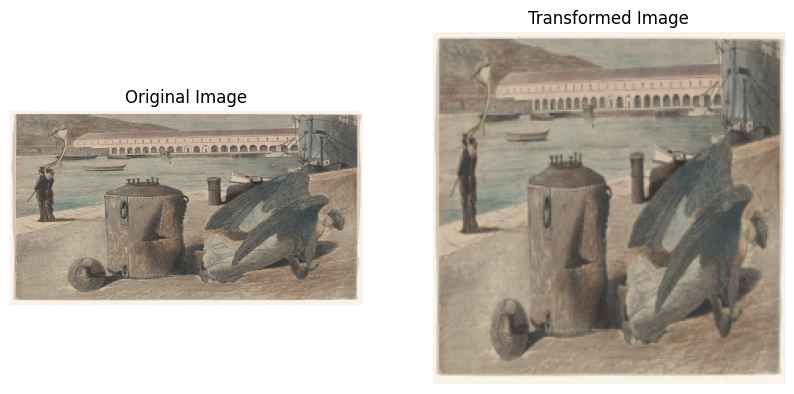

In [63]:
def imshow(tensor, title="Transformed Image"):
  # unnormalize transformed image
  tensor = tensor * torch.tensor([0.229, 0.224, 0.225]).view(3,1,1) + torch.tensor([0.485, 0.456, 0.406]).view(3,1,1)
  tensor = tensor.clamp(0,1)
  np_img = tensor.permute(1,2,0).numpy()
  plt.imshow(np_img)
  plt.title(title)
  plt.axis("off")
  plt.show()

# select one from train set
image_tensor, label_tensor = train_dataset[10]

# get the same image from original images
object_id = train_df.iloc[10]["ObjectID"]
img_path = f"{image_path}/{object_id}.jpg"
orig_image = Image.open(img_path)

# plot side by side
plt.figure(figsize=(10,5))

plt.subplot(1,2,1)
plt.imshow(orig_image)
plt.title("Original Image")
plt.axis('off')

plt.subplot(1,2,2)
imshow(image_tensor)

plt.show()

### Model Setup


In [64]:
# setup device (gpu vs cpu)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cpu


#### Evaluation Function

I define a function to evaluate the performance of the multi-class classification model on a given dataset.

The function sets the model to evaluation mode to disable dropout and batch normalization updates. It then iterates over the DataLoader without computing gradients, obtaining predictions for each batch by taking the class with the highest output probability. True labels and predicted labels are collected across all batches. Finally, I calculate macro-averaged F1 score, precision, and recall to assess the model’s overall performance across all classes, giving equal weight to each class.

In [65]:
"""
Evaluation Function
"""

def evaluate_model(model, data_loader, device, loss_fn=None):
  # get model in evaluation mode
  model.eval()

  # for store results
  all_targets, all_preds = [], []
  total_loss = 0.0
  num_samples = 0

  # disable gradient computation
  with torch.no_grad():
    for images, targets in data_loader:

      # move batches to chosen device
      images, targets = images.to(device), targets.to(device)

      # predict logits for each class
      outputs = model(images)

      # Loss computation (optional)
      if loss_fn is not None:
          batch_loss = loss_fn(outputs, targets).item()
          total_loss += batch_loss * images.size(0)
          num_samples += images.size(0)


      # the predicted class
      _, preds = torch.max(outputs, 1)

      # get the preds and targets
      all_targets.extend(targets.cpu().numpy())
      all_preds.extend(preds.cpu().numpy())


    metrics = {
        "accuracy": accuracy_score(all_targets, all_preds),
        "f1": f1_score(all_targets, all_preds, average="macro"),
        "precision": precision_score(all_targets, all_preds, average="macro"),
        "recall": recall_score(all_targets, all_preds, average="macro")
    }

    if loss_fn is not None and num_samples > 0:
        metrics["loss"] = total_loss / num_samples

    return metrics



#### Pretrained ResNet50

For this classification task (3 classes, 3000 images per class), I use a pretrained ResNet50 as the backbone.

Instead of training the entire model from scratch, I freeze the early layers (up to layer2), since they learn general low-level features such as edges and textures, which are transferable across tasks.

I unfreeze layer3, layer4, and the fully connected (fc) layer so that the model can adapt higher-level, task-specific features to my dataset. This approach balances training efficiency (fewer parameters to optimize) and model adaptability (still learns domain-specific patterns).

I replace the last fully connected layer with a new nn.Linear layer to match the number of classes (num_class), use CrossEntropyLoss for single-label classification, Adam optimizer to update only the unfrozen layers, and a ReduceLROnPlateau scheduler to reduce the learning rate if validation loss plateaus.

In [66]:
"""
Model Setup
"""

num_class = len(class_index)

# load pretrained ResNet50
model = models.resnet50(pretrained=True)

# replace final fully connected layer to match number of classes
model.fc = nn.Linear(model.fc.in_features, num_class)

# freeze only first three layers
for name, param in model.named_parameters():
  if "layer4" not in name and "fc" not in name:
    param.requires_grad = False

# check model
for name, param in model.named_parameters():
  if param.requires_grad:
    print(f" {name}")

 layer4.0.conv1.weight
 layer4.0.bn1.weight
 layer4.0.bn1.bias
 layer4.0.conv2.weight
 layer4.0.bn2.weight
 layer4.0.bn2.bias
 layer4.0.conv3.weight
 layer4.0.bn3.weight
 layer4.0.bn3.bias
 layer4.0.downsample.0.weight
 layer4.0.downsample.1.weight
 layer4.0.downsample.1.bias
 layer4.1.conv1.weight
 layer4.1.bn1.weight
 layer4.1.bn1.bias
 layer4.1.conv2.weight
 layer4.1.bn2.weight
 layer4.1.bn2.bias
 layer4.1.conv3.weight
 layer4.1.bn3.weight
 layer4.1.bn3.bias
 layer4.2.conv1.weight
 layer4.2.bn1.weight
 layer4.2.bn1.bias
 layer4.2.conv2.weight
 layer4.2.bn2.weight
 layer4.2.bn2.bias
 layer4.2.conv3.weight
 layer4.2.bn3.weight
 layer4.2.bn3.bias
 fc.weight
 fc.bias


In [67]:
# hyperparameters
num_epochs = 5
batch_size = 32

# dir for checkpoint and plots
checkpoint_dir = "PATH_TO_CHECKPOINT"
os.makedirs(checkpoint_dir, exist_ok=True)

# collect trainable parameters
trainable_params = [p for p in model.parameters() if p.requires_grad]

# optimizer
optimizer = torch.optim.Adam(params=trainable_params, lr=1e-4)

# loss function
loss_fn = nn.CrossEntropyLoss()

# learning rate scheduler.
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer,
    mode='min',  # decrease loss
    factor=0.5,  # reduce half
    patience=2  # wait for 2 epoch
)


In [69]:
"""
Function for saving and loading checkpoints and metrics
Checkpoints include epoch, batch, model_state, optimizer state, scheduler state,
loss, best_val_loss
"""


# to save
def save_checkpoint(model, optimizer, scheduler, epoch, batch_index, loss, best_val_loss, save_path):
  temp_path = save_path + ".tmp"
  torch.save({
      "epoch": epoch,
      "batch_index": batch_index,
      "model_state": model.state_dict(),
      "optimizer_state_dict": optimizer.state_dict(),
      "scheduler_state_dict": scheduler.state_dict(),
      "loss": loss,
      "best_val_loss": best_val_loss
  }, temp_path)
  os.rename(temp_path, save_path)


# to load
def load_checkpoint(model, optimizer, scheduler, path, device):
    checkpoint = torch.load(path, map_location=device)
    model.load_state_dict(checkpoint["model_state"])
    optimizer.load_state_dict(checkpoint["optimizer_state_dict"])
    scheduler.load_state_dict(checkpoint["scheduler_state_dict"])
    return (
        model, optimizer, scheduler,
        checkpoint["epoch"] - 1,
        checkpoint.get("batch_index", 0),
        checkpoint.get("loss", float("inf")),
        checkpoint.get("best_val_loss", float("inf"))
    )


# function to load metrics. the metrics are saved during each training
def load_metrics(path):
    if os.path.exists(path):
        with open(path, "rb") as f:
            metrics = pickle.load(f)
        print(f"Loaded metrics from {path}")
        return (
            metrics.get("train_losses_epoch", []),
            metrics.get("val_losses_epoch", []),
            metrics.get("val_accuracies_epoch", []),
            metrics.get("train_losses_batch", []),
            metrics.get("batch_indices", [])
        )
    print("No saved metrics found. Starting from scratch.")
    return ([], [], [], [], [])


#### Resume checkpoint if exist

In [73]:
"""
Load saved metrics and checkpoint if available
"""

# metrics
metrics_path = os.path.join(checkpoint_dir, "metrics.pkl")
train_losses_epoch, val_losses_epoch, val_accuracies_epoch, train_losses_batch, batch_indices = load_metrics(metrics_path)

# resume from latest checkpoint
latest_checkpoint = max(glob.glob(os.path.join(checkpoint_dir, "checkpoint_*.pt")), default=None)
if latest_checkpoint:
    print(f"Resuming from {latest_checkpoint}")
    model, optimizer, scheduler, start_epoch, start_batch, loss, best_val_loss = load_checkpoint(
        model, optimizer, scheduler, latest_checkpoint, device)
else:
    print("No checkpoint found. Starting from scratch.")
    start_epoch, start_batch, best_val_loss = 0, 0, float("inf")

No saved metrics found. Starting from scratch.
No checkpoint found. Starting from scratch.


#### Training loop

In [74]:
"""
Training Loop
"""


for epoch in range(start_epoch, num_epochs):
    print(f"\n--- Epoch {epoch+1}/{num_epochs} ---")
    model.train()
    running_loss = 0.0

    for batch_idx, (images, targets) in enumerate(train_loader):
        # skip batches already processed if resuming mid-epoch
        if epoch == start_epoch and batch_idx < start_batch:
            continue

        images, targets = images.to(device), targets.to(device).long()
        optimizer.zero_grad()
        outputs = model(images)
        loss = loss_fn(outputs, targets)
        loss.backward()
        optimizer.step()

        # track batch-level loss
        train_losses_batch.append(loss.item())
        batch_indices.append(epoch + batch_idx / len(train_loader))
        running_loss += loss.item() * images.size(0)

        # print progress every 20 batch
        if (batch_idx + 1) % 20 == 0:
            print(f"Epoch {epoch+1}, Batch {batch_idx+1}/{len(train_loader)} - Loss: {loss.item():.4f}")

        # save checkpoint every 50 batches
        if (batch_idx + 1) % 50 == 0:
            # remove previous checkpoint(s)
            old_checkpoints = glob.glob(os.path.join(checkpoint_dir, "checkpoint_epoch*.pt"))
            for old_ckpt in old_checkpoints:
                os.remove(old_ckpt)

            save_checkpoint(
                model=model,
                optimizer=optimizer,
                scheduler=scheduler,
                epoch=epoch+1,
                batch_index=batch_idx+1,
                loss=loss.item(),
                best_val_loss=best_val_loss,
                save_path=os.path.join(checkpoint_dir, f"checkpoint_epoch{epoch+1}_batch{batch_idx+1}.pt")
            )

    # compute epoch-level training loss
    epoch_loss = running_loss / len(train_loader.dataset)
    train_losses_epoch.append(epoch_loss)

    # evaluate model on test set
    metrics = evaluate_model(model, test_loader, device, loss_fn=loss_fn)
    test_loss = metrics["loss"] if "loss" in metrics else float("inf")
    test_accuracy = metrics["accuracy"]
    f1 = metrics['f1']
    precision = metrics['precision']
    recall = metrics['recall']

    # update scheduler and epoch-level metrics
    scheduler.step(test_loss)
    val_losses_epoch.append(test_loss)
    val_accuracies_epoch.append(test_accuracy)

    print(f"Epoch [{epoch+1}/{num_epochs}] Completed | Train Loss: {epoch_loss:.4f} | Test Loss: {test_loss:.4f} | Test Acc: {test_accuracy:.4f}")
    print(f"F1: {f1:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}")

    # save best model based on test loss
    if test_loss < best_val_loss:
        best_val_loss = test_loss
        torch.save(model.state_dict(), os.path.join(checkpoint_dir, "best_model.pt"))

    # reset batch counter after epoch
    start_batch = 0

    # save metrics after each epoch
    metrics = {
        'train_losses_epoch': train_losses_epoch,
        'val_losses_epoch': val_losses_epoch,
        'val_accuracies_epoch': val_accuracies_epoch,
        'train_losses_batch': train_losses_batch,
        'batch_indices': batch_indices
    }
    with open(metrics_path, 'wb') as f:
        pickle.dump(metrics, f)


--- Epoch 1/5 ---
Epoch 1, Batch 20/240 - Loss: 0.6718
Epoch 1, Batch 40/240 - Loss: 0.3157
Epoch 1, Batch 60/240 - Loss: 0.4245
Epoch 1, Batch 80/240 - Loss: 0.4865
Epoch 1, Batch 100/240 - Loss: 0.4549
Epoch 1, Batch 120/240 - Loss: 0.5390
Epoch 1, Batch 140/240 - Loss: 0.7617
Epoch 1, Batch 160/240 - Loss: 0.4658
Epoch 1, Batch 180/240 - Loss: 0.3110
Epoch 1, Batch 200/240 - Loss: 0.2285
Epoch 1, Batch 220/240 - Loss: 0.3625
Epoch 1, Batch 240/240 - Loss: 0.5434
Epoch [1/5] Completed | Train Loss: 0.4368 | Test Loss: 0.3118 | Test Acc: 0.8770
F1: 0.8750, Precision: 0.8751, Recall: 0.8750

--- Epoch 2/5 ---
Epoch 2, Batch 20/240 - Loss: 0.1659
Epoch 2, Batch 40/240 - Loss: 0.2277
Epoch 2, Batch 60/240 - Loss: 0.1520
Epoch 2, Batch 80/240 - Loss: 0.1152
Epoch 2, Batch 100/240 - Loss: 0.2336
Epoch 2, Batch 120/240 - Loss: 0.2799
Epoch 2, Batch 140/240 - Loss: 0.4808
Epoch 2, Batch 160/240 - Loss: 0.3644
Epoch 2, Batch 180/240 - Loss: 0.2775
Epoch 2, Batch 200/240 - Loss: 0.1359
Epoch 

In [77]:
"""
Plot metrics
"""


def plot_metrics(metrics_path, save_name="final_loss_accuracy_plot.png"):
    """Plot training & validation loss/accuracy from saved metrics."""
    if not os.path.exists(metrics_path):
        print(f"No metrics file found at {metrics_path}. Cannot plot.")
        return

    with open(metrics_path, 'rb') as f:
        metrics = pickle.load(f)
        train_losses_epoch = metrics.get('train_losses_epoch', [])
        val_losses_epoch = metrics.get('val_losses_epoch', [])
        val_accuracies_epoch = metrics.get('val_accuracies_epoch', [])
        train_losses_batch = metrics.get('train_losses_batch', [])
        batch_indices = metrics.get('batch_indices', [])

    if not train_losses_epoch:
        print("No metrics recorded yet. Train your model before plotting.")
        return

    epochs = list(range(1, len(train_losses_epoch) + 1))
    plt.figure(figsize=(12, 5))

    # --- Loss Plot ---
    plt.subplot(1, 2, 1)
    if train_losses_batch:
        plt.plot(batch_indices, train_losses_batch, label='Train Loss (batch)', alpha=0.3, color='blue')
    plt.plot(epochs, train_losses_epoch, label='Train Loss (epoch)', marker='o', color='blue')
    plt.plot(epochs, val_losses_epoch, label='Validation Loss', marker='o', color='orange')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training & Validation Loss')
    plt.legend()
    plt.grid(True)

    # accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, val_accuracies_epoch, label='Validation Accuracy', marker='o', color='green')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Validation Accuracy')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()

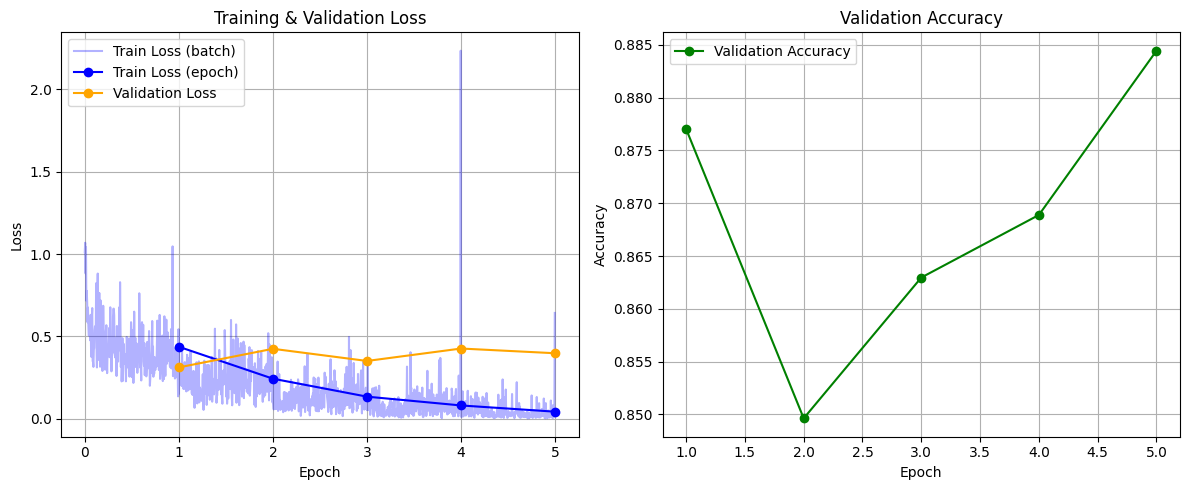

In [78]:
plot_metrics(metrics_path)

In [80]:
# save model weights
model_path = "PATH_TO_MODEL"
os.makedirs(model_path, exist_ok=True)
model_file = os.path.join(model_path, "momaclassifier_resnet50.pt")
torch.save(model.state_dict(), model_file)
print(f"Model weights saved at: {model_file}")

# save model metadata
metadata = {
    "model": "resnet50",
    "num_classes": num_class,
    "notes": "Fine-tuned layer4 + fc on MoMA dataset"
}
with open(os.path.join(model_path, "momaclassifier_resnet50_meta.json"), "w") as f:
    json.dump(metadata, f, indent=4)
print("Model metadata saved.")

Model weights saved at: /content/drive/MyDrive/ML-PROJECTS/MoMA/models/momaclassifier_resnet50.pt
Model metadata saved.
